In [1]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('C:/Users/madha/Downloads/bank+marketing/bank/bank-full.csv', delimiter=';')

In [5]:
cols = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

In [7]:
df = df[cols]

In [9]:
df.y = (df.y == 'yes').astype(int)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
np.random.seed(42)

In [14]:
df_fulltrain , df_test = train_test_split(df,test_size = 0.2, random_state= 1)
df_train , df_val = train_test_split(df_fulltrain,test_size = 0.25, random_state= 1)

In [16]:
y_fulltrain = df_fulltrain.y.values
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [18]:
del df_train['y']
del df_val['y']
del df_test['y']

In [20]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

# Question 1

In [30]:
from sklearn.metrics import roc_auc_score

numerical_vars = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

for var in numerical_vars:
    auc = roc_auc_score(y_train, df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    auc_scores[var] = auc

highest_auc_var = max(auc_scores, key=auc_scores.get)

print("AUC scores for each variable:", auc_scores)
print("Variable with the highest AUC:", highest_auc_var)


AUC scores for each variable: {'balance': 0.5888313805382317, 'day': 0.525957882383908, 'duration': 0.8147002759670778, 'previous': 0.5985653242764153}
Variable with the highest AUC: duration


# Question 2

In [33]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [35]:
dicts = df_train.to_dict(orient='records')
dv=DictVectorizer(sparse=False)
x_train =dv.fit_transform(dicts)
model = LogisticRegression(solver='liblinear',max_iter=1000,C=1.0)
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [43]:
val_dict = df_val.to_dict(orient = 'records')

x_val = dv.transform(val_dict)

y_pred = model.predict_proba(x_val)[:,1]

roc_auc_score(y_val, y_pred).round(4)

0.9004

# Question 3

In [64]:

val_dict = df_val.to_dict(orient = 'records')

x_val = dv.transform(val_dict)

y_pred = model.predict_proba(x_val)[:,1]

scores = []

thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [66]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [68]:
df_scores['precision']= df_scores.tp /(df_scores.tp + df_scores.fp)
df_scores['recall']= df_scores.tp/(df_scores.tp + df_scores.fn)

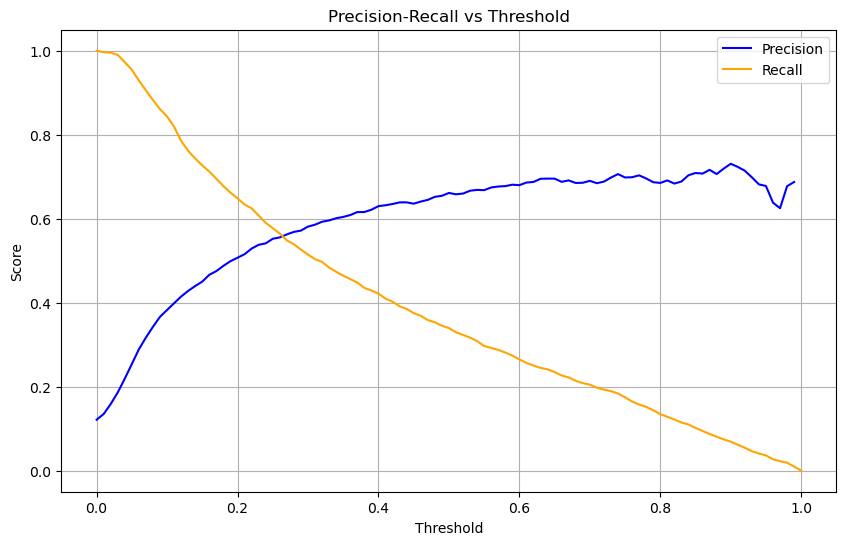

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, df_scores['precision'], label="Precision", color="blue")
plt.plot(thresholds, df_scores['recall'], label="Recall", color="orange")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Question 4

In [79]:
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

df_scores['f1_score'] = df_scores.apply(lambda row: f1_score(row['precision'], row['recall']), axis=1)


In [89]:
max_f1_row = df_scores.loc[df_scores['f1_score'].idxmax()]

max_f1_threshold = max_f1_row['threshold']
max_f1_value = max_f1_row['f1_score']

print("Threshold at max F1 score:", max_f1_threshold)
print("Max F1 score:", max_f1_value)


Threshold at max F1 score: 0.22
Max F1 score: 0.5728601252609603


# Question 5

In [92]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5,shuffle = True,random_state =1)

In [94]:
def train(df_train,y_train,C=1.0):
    dicts = df_train.to_dict(orient='records')
    dv=DictVectorizer(sparse=False)
    x_train =dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear',max_iter=1000,C=C)
    model.fit(x_train,y_train)
    return dv, model

In [96]:
dv,model = train(df_train,y_train)

In [100]:
def predict(df,dv,model):
    dicts = df.to_dict(orient='records')
    x =dv.transform(dicts)
    y_pred = model.predict_proba(x)[:,1]
    return y_pred

In [102]:
y_pred = predict(df_val,dv,model)

In [128]:
scores=[]
for train_idx, val_idx in kfold.split(df_fulltrain):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]

        y_train = df_train.y
        y_val = df_val.y

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

In [130]:
scores

[0.9999994801659934, 1.0, 1.0, 1.0, 1.0]

In [144]:
auc_std = np.std(scores)
auc_std.round(8)

2.1e-07

# Question 6

In [153]:
from tqdm.auto import tqdm


In [155]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_fulltrain):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]

        y_train = df_train.y
        y_val = df_val.y

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.702 +- 0.009
C=0.001 0.987 +- 0.003
C=1 1.000 +- 0.000
